The following Jupyter notebook is sourced here: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [183]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Some environment variable 'libiomp5md.dll' is causing kernel crashes, this is just to fix it for now.

import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [184]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = "~/datasets"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

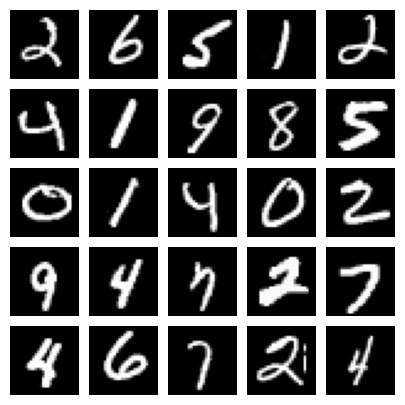

In [185]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap="gray")
    ax.axis("off")

plt.show()

In [186]:
class Encoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [187]:
class Decoder(nn.Module):

    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))

        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [188]:
class VAE(nn.Module):

    def __init__(
        self, input_dim=784, hidden1_dim=400, hidden2_dim=200, latent_dim=2, device=device
    ):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden1_dim, hidden2_dim),
            nn.LeakyReLU(0.2),
        ).to(device)

        # latent mean and Cholesky decomp of covariance
        self.mean_layer = nn.Linear(hidden2_dim, latent_dim, device=device)
        self.chol_layer = nn.Linear(
            hidden2_dim, (latent_dim * (latent_dim + 1)) // 2, device=device
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden2_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden2_dim, hidden1_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden1_dim, input_dim),
            nn.Sigmoid(),
        ).to(device)

    def encode(self, x):
        x = self.encoder(x)
        mean, chol = self.mean_layer(x), self.chol_layer(x)
        return mean, chol

    def reparameterization(self, mean, chol):
        epsilon = torch.randn_like(mean, device=self.device)
        batch_size = mean.shape[0]
        L = torch.zeros(batch_size, self.latent_dim, self.latent_dim, device=self.device)
        tril_indices = torch.tril_indices(
            self.latent_dim, self.latent_dim, offset=0, device=self.device
        )
        L[:, tril_indices[0], tril_indices[1]] = chol
        z = mean + torch.einsum("bij,bj->bi", L, epsilon)
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, chol = self.encode(x)
        z = self.reparameterization(mean, chol)
        x_hat = self.decode(z)
        return x_hat, mean, chol

In [189]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [190]:
class UnFlatten(nn.Module):
    def forward(self, input, size=7*7*32):
        return input.view(input.size(0), size, 1, 1)

In [191]:
class CNN_VAE(nn.Module):

    def __init__(
        self, input_dim=784, latent_dim=4, device=device
    ):
        super(CNN_VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 28 to 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 to 14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 14 to 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 to 7            
        ).to(device)

        # latent mean and Cholesky decomp of covariance
        self.fc1 = nn.Linear(7*7*32, 7*7*16)
        self.fc2 = nn.Linear(7*7*16, 7*7*8)
        self.fc3 = nn.Linear(7*7*8, 7*7*16)
        self.fc4 = nn.Linear(7*7*16, 7*7*32)
        self.mean_layer = nn.Linear(7*7*8, latent_dim, device=device)
        self.chol_layer = nn.Linear(7*7*8, (latent_dim * (latent_dim + 1)) // 2, device=device)
        self.decode_layer = nn.Linear(latent_dim, 7*7*8)

        # decoder
        self.decoder = nn.Sequential(
            nn.Upsample((14,14)),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # 14 to 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample((28,28)),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid(),
        ).to(device)
        
    def encode(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = x.view(x.size(0), -1) # Flattening...
        x = self.fc1(x)
        x = self.fc2(x)
        # print(x.shape)
        mean, chol = self.mean_layer(x), self.chol_layer(x)
        return mean, chol

    def reparameterization(self, mean, chol):
        epsilon = torch.randn_like(mean, device=self.device)
        batch_size = mean.shape[0]
        L = torch.zeros(batch_size, self.latent_dim, self.latent_dim, device=self.device)
        tril_indices = torch.tril_indices(
            self.latent_dim, self.latent_dim, offset=0, device=self.device
        )
        L[:, tril_indices[0], tril_indices[1]] = chol
        z = mean + torch.einsum("bij,bj->bi", L, epsilon)
        return z

    def decode(self, x):
        x = self.decode_layer(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = x.view(x.size(0), 32, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mean, chol = self.encode(x)
        z = self.reparameterization(mean, chol)
        x_hat = self.decode(z)
        return x_hat, mean, chol

The following is a modification of the VAE using a convolutional network. 
https://www.datacamp.com/tutorial/pytorch-cnn-tutorial
https://github.com/sksq96/pytorch-vae/blob/master/vae.py

In [192]:
model = CNN_VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [193]:
def loss_function(x, x_hat, mean, chol):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")

    batch_size = mean.shape[0]
    L = torch.zeros(batch_size, model.latent_dim, model.latent_dim, device=model.device)
    tril_indices = torch.tril_indices(
        model.latent_dim, model.latent_dim, offset=0, device=model.device
    )
    L[:, tril_indices[0], tril_indices[1]] = chol

    Sigma = torch.einsum("bij,bkj->bik", L, L)

    KLD = 0.5 * (
        torch.mean(torch.sum(mean.pow(2), axis=-1))
        + torch.mean(torch.sum(torch.diagonal(Sigma, offset=0, dim1=-2, dim2=-1), axis=-1))
        - torch.mean(torch.linalg.slogdet(Sigma).logabsdet)
        - model.latent_dim
    )

    return reproduction_loss + KLD

In [194]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device) # x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    return overall_loss

In [195]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  166.02534440538918
	Epoch 2 	Average Loss:  137.91533816125835
	Epoch 3 	Average Loss:  133.87440959541945
	Epoch 4 	Average Loss:  134.02782027663292
	Epoch 5 	Average Loss:  133.23831884521076
	Epoch 6 	Average Loss:  132.58334621830656
	Epoch 7 	Average Loss:  132.53760378625836
	Epoch 8 	Average Loss:  131.20790764555508
	Epoch 9 	Average Loss:  130.30394410606218
	Epoch 10 	Average Loss:  129.66871842067508
	Epoch 11 	Average Loss:  129.84281113053004
	Epoch 12 	Average Loss:  128.21689030871767
	Epoch 13 	Average Loss:  127.8867716376252
	Epoch 14 	Average Loss:  127.8857817227932
	Epoch 15 	Average Loss:  126.88333113783389
	Epoch 16 	Average Loss:  131.86035355149207
	Epoch 17 	Average Loss:  131.18070201638147
	Epoch 18 	Average Loss:  128.98501529241443
	Epoch 19 	Average Loss:  127.84239137168719
	Epoch 20 	Average Loss:  129.55260765012
	Epoch 21 	Average Loss:  128.5634345328151
	Epoch 22 	Average Loss:  126.90373945182074
	Epoch 23 	Average Loss: 

7661901.861328125

In [196]:
def generate_digit(latent_vec):
    z_sample = torch.tensor([latent_vec], dtype=torch.float, device=model.device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f"[{latent_vec[0]},{latent_vec[1]}]")
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()

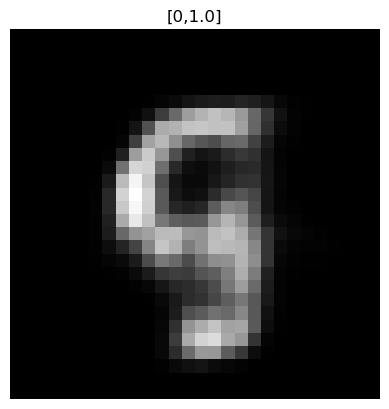

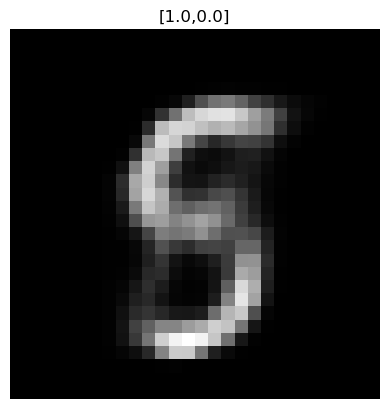

(None, None)

In [ ]:
generate_digit([0, 1.0,1,0]), generate_digit([1.0, 0.0,0,0])

## Visualize the embedding of the training examples

In [15]:
from collections import defaultdict

encoded_reps = defaultdict(list)

for batch_idx, (x, labels) in enumerate(train_loader):
    x = x.view(batch_size, 784).to(device)
    mean_reps, chol_rep = model.encode(x)
    for rep, label in zip(mean_reps, labels):
        encoded_reps[int(label)].append(rep.detach().cpu().numpy())

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100, 784]

In [ ]:
fig = plt.figure()
ax = fig.gca()
for label in range(10):
    ax.scatter(*zip(*encoded_reps[label]), s=1, label=str(label))

fig.legend()

## Visualize the generative model

In [198]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi,0,0]], dtype=torch.float, device=model.device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualization")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z [0]")
    plt.ylabel("z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

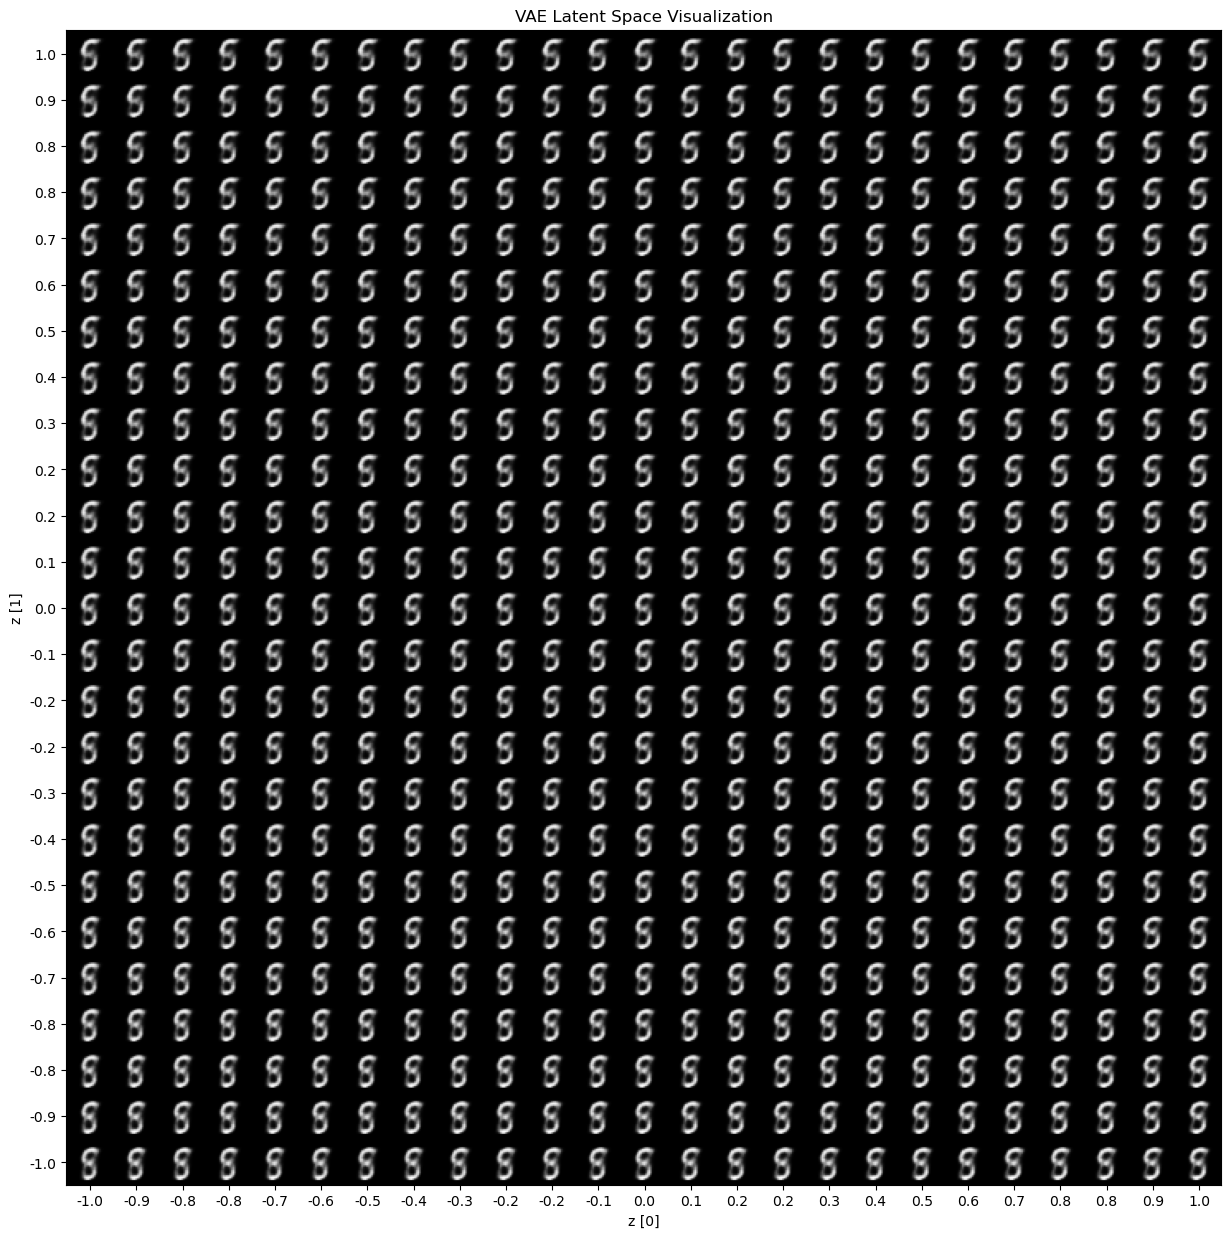

In [199]:
plot_latent_space(model, scale=1.0)

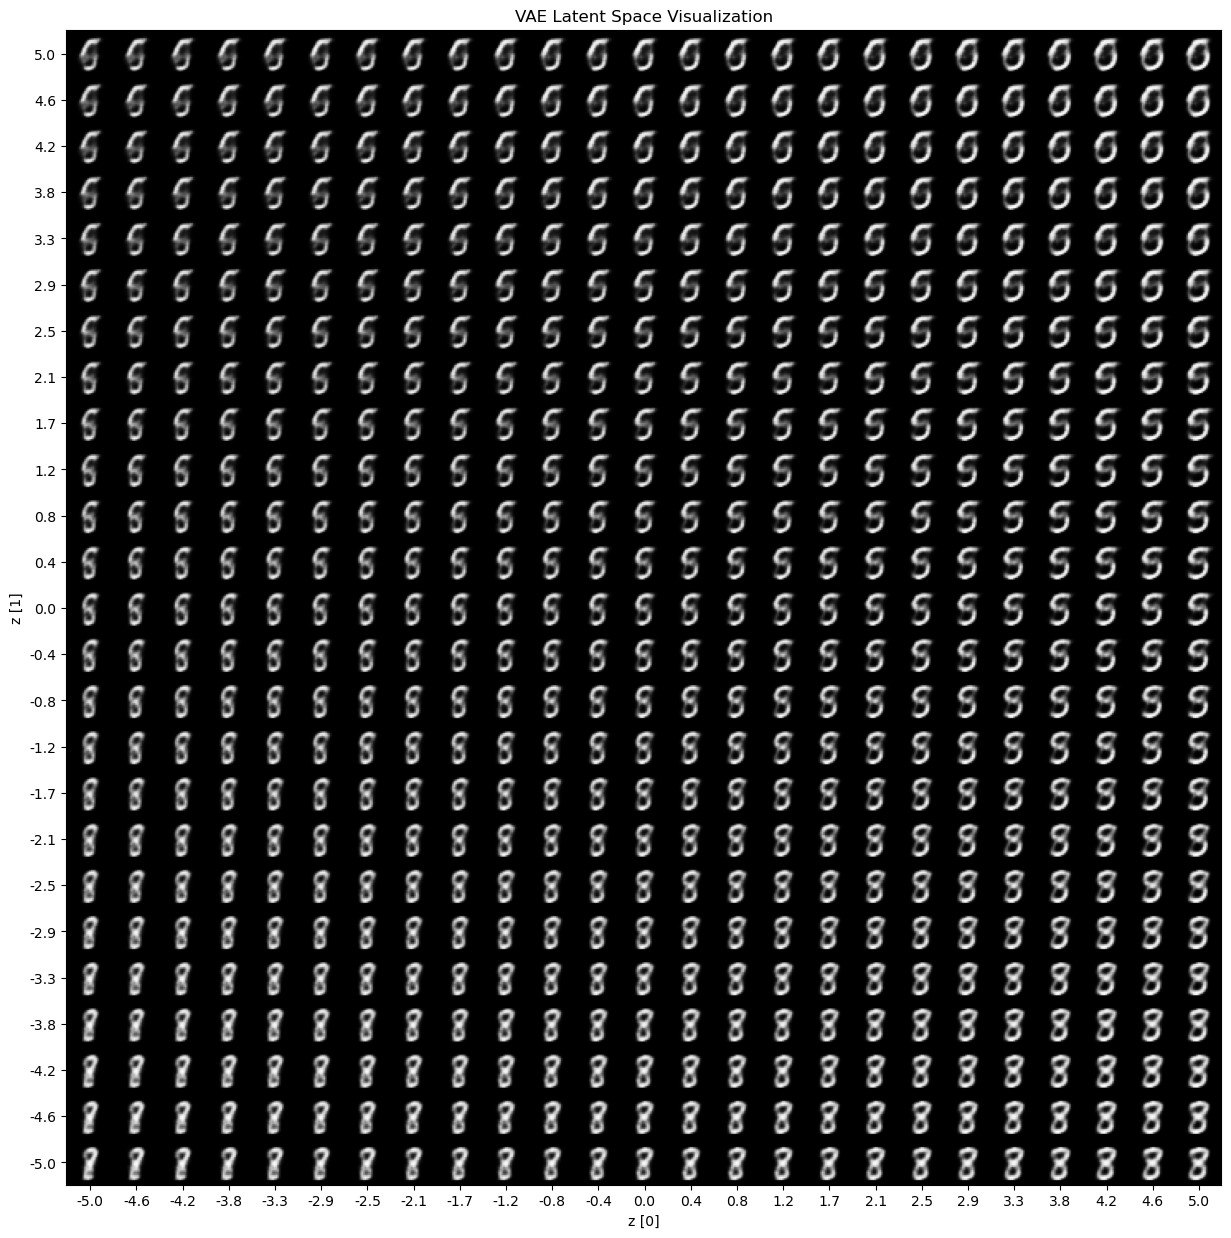

In [200]:
plot_latent_space(model, scale=5.0)